In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import h5py
import vigra
import numpy as np
import elf.segmentation.features as feats
from skimage import draw
from skimage.filters import gaussian
from skimage.transform import rotate
from skimage.segmentation import relabel_sequential
from affogato.segmentation import compute_mws_segmentation
from elf.segmentation.features import project_node_labels_to_pixels
from elf.segmentation.multicut import multicut_decomposition
import matplotlib.pyplot as plt
from matplotlib import cm
import napari
from elf.segmentation import compute_rag
import imageio.v2 as imageio
from rag_utils import find_dense_subgraphs
import torch
from graphs import get_edge_indices, collate_edges
from lines_reward import HoughLinesReward
from circles_reward import HoughCirclesReward

In [3]:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

In [22]:
def rew_f(super_pixel, pred_img, s_subgraph, RewardFunction):
    super_pixelT = torch.from_numpy(super_pixel)
    pred_imgT = torch.from_numpy(pred_img)
    graph = compute_rag(super_pixelT)
    edge_ids = graph.uvIds().T
    edge_ids = edge_ids.astype(np.int64)
    edge_ids, fw, inv = relabel_sequential(edge_ids)
    edge_ids = torch.from_numpy(edge_ids)
    edge_ids = [edge_ids]
    dir_edge_ids = [torch.cat([_edge_ids, torch.stack([_edge_ids[1], _edge_ids[0]], dim=0)], dim=1) for _edge_ids in edge_ids]
    _subgraphs, _sep_subgraphs = find_dense_subgraphs([eids.transpose(0, 1).cpu().numpy() for eids in edge_ids], s_subgraph)
    
    bs = 1
    _subgraphs = [torch.from_numpy(sg.astype(np.int64)).permute(2, 0, 1) for sg in _subgraphs]
    _sep_subgraphs = [torch.from_numpy(sg.astype(np.int64)).permute(2, 0, 1) for sg in _sep_subgraphs]
    _edge_ids, (n_offs, e_offs) = collate_edges(edge_ids)
    subgraphs, sep_subgraphs = [], []
    
    for i in range(len(s_subgraph)):
        subgraphs.append(torch.cat([sg + n_offs[i] for i, sg in enumerate(_subgraphs[i*bs:(i+1)*bs])], -2).flatten(-2, -1))
        sep_subgraphs.append(torch.cat(_sep_subgraphs[i*bs:(i+1)*bs], -2).flatten(-2, -1))

    SI = get_edge_indices(_edge_ids, subgraphs)
    
    reward_function = RewardFunction(s_subgraph)

    pred_imgT = torch.unsqueeze(pred_imgT, 0)
    super_pixelT = torch.unsqueeze(super_pixelT, 0)

    reward = reward_function(prediction_segmentation = pred_imgT,
                             gt = None, dir_edges = dir_edge_ids,
                             superpixel_segmentation = super_pixelT,
                             node_feats = None, actions = None,
                             subgraph_indices = SI, sg_gt_edges = None)

    return reward
    

## Lines with Line Reward Function

In [37]:
main_img = imageio.imread("/home/zarvandi/unsup_pix_embed/line.png")
main_img = torch.from_numpy(main_img)

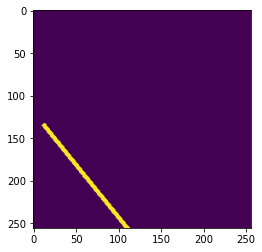

In [39]:
plt.imshow(main_img)

In [5]:
super_pixel = imageio.imread("/home/zarvandi/unsup_pix_embed/suppix.tif")

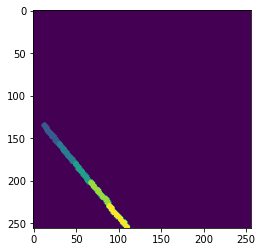

In [5]:
plt.imshow(super_pixel)

In [6]:
pred_img1 = imageio.imread("/home/zarvandi/unsup_pix_embed/merged1.tif")
pred_img2 = imageio.imread("/home/zarvandi/unsup_pix_embed/merged2.tif")
pred_img3 = imageio.imread("/home/zarvandi/unsup_pix_embed/merged3.tif")
pred_img4 = imageio.imread("/home/zarvandi/unsup_pix_embed/merged4.tif")

In [7]:
s_subgraph = [4]

In [8]:
rew_f(super_pixel, pred_img1, s_subgraph, HoughLinesReward)

([tensor([0.0538, 0.0538, 0.0558, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

In [9]:
rew_f(super_pixel, pred_img2, s_subgraph, HoughLinesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

In [10]:
rew_f(super_pixel, pred_img3, s_subgraph, HoughLinesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

In [11]:
rew_f(super_pixel, pred_img4, s_subgraph, HoughLinesReward)

([tensor([0.0538, 0.0538, 0.0558, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

In [38]:
# zero_img = np.zeros_like(img)
# np.allclose(img, zero_img)

In [36]:
# zeroT_img = torch.zeros_like(img)
# torch.allclose(img, zeroT_img)

## Lines with Circle Reward Function

In [19]:
rew_f(super_pixel, pred_img1, s_subgraph, HoughCirclesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

In [23]:
rew_f(super_pixel, pred_img2, s_subgraph, HoughCirclesReward)

([tensor([0.0558, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

In [26]:
rew_f(super_pixel, pred_img3, s_subgraph, HoughCirclesReward)

([tensor([0.0558, 0.0558, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

In [27]:
rew_f(super_pixel, pred_img4, s_subgraph, HoughCirclesReward)

([tensor([0.0538, 0.0558, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0542))

## Circles with Line Reward function

In [28]:
main_img_crl = imageio.imread("/home/zarvandi/unsup_pix_embed/circle.png")
main_img_crl = torch.from_numpy(main_img_crl)

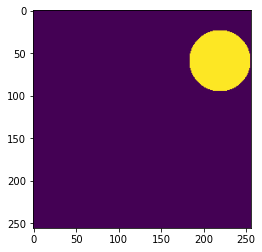

In [29]:
plt.imshow(main_img_crl)

In [12]:
super_pixel_crl = imageio.imread("/home/zarvandi/unsup_pix_embed/suppix_crl.tif")

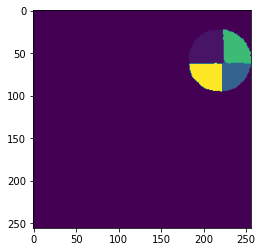

In [15]:
plt.imshow(super_pixel_crl)

In [13]:
pred_img1_crl = imageio.imread("/home/zarvandi/unsup_pix_embed/merged1_crl.tif")
pred_img2_crl = imageio.imread("/home/zarvandi/unsup_pix_embed/merged2_crl.tif")
pred_img3_crl = imageio.imread("/home/zarvandi/unsup_pix_embed/merged3_crl.tif")

In [14]:
rew_f(super_pixel_crl, pred_img1_crl, s_subgraph, HoughLinesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0534))

In [15]:
rew_f(super_pixel_crl, pred_img2_crl, s_subgraph, HoughLinesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0534))

In [24]:
rew_f(super_pixel_crl, pred_img3_crl, s_subgraph, HoughLinesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0534))

## Circles with Circle Reward Function

In [20]:
rew_f(super_pixel_crl, pred_img1_crl, s_subgraph, HoughCirclesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0534))

In [21]:
rew_f(super_pixel_crl, pred_img2_crl, s_subgraph, HoughCirclesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0534))

In [25]:
rew_f(super_pixel_crl, pred_img3_crl, s_subgraph, HoughCirclesReward)

([tensor([0.0538, 0.0538, 0.0538, 0.0538, 0.0538])],
 [tensor([0.0498, 0.0498, 0.0498, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])],
 tensor(0.0534))